In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
import seaborn as sb
from matplotlib import colors

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(6, 4))
sc.settings.verbosity = 3

np.random.seed(2211)

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


Load final preprocessed data from *exp_04/all_genes* or *exp_04/variable_genes* and do analysis for marker genes

In [2]:
dataset = 'E13_hom'
adata = sc.read('../ann_data/exp_04/' + dataset + '_norm_variable_genes.h5ad')
adata

AnnData object with n_obs × n_vars = 6222 × 1722
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
marker_genes = dict()
marker_genes['neural_progen'] = ['Pax6', 'Vim', 'Sox2']
# marker_genes['neural_progen'] = ['Pax6', 'Sox2']
marker_genes['intermediate_progen'] = ['Eomes', 'Btg2']
marker_genes['post_mitotic'] = ['Tbr1', 'Sox5']
marker_genes['ectopic'] = ['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1',
                           'Gad2', 'Ptf1a', 'Msx3', 'Helt', 'Olig3']


#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


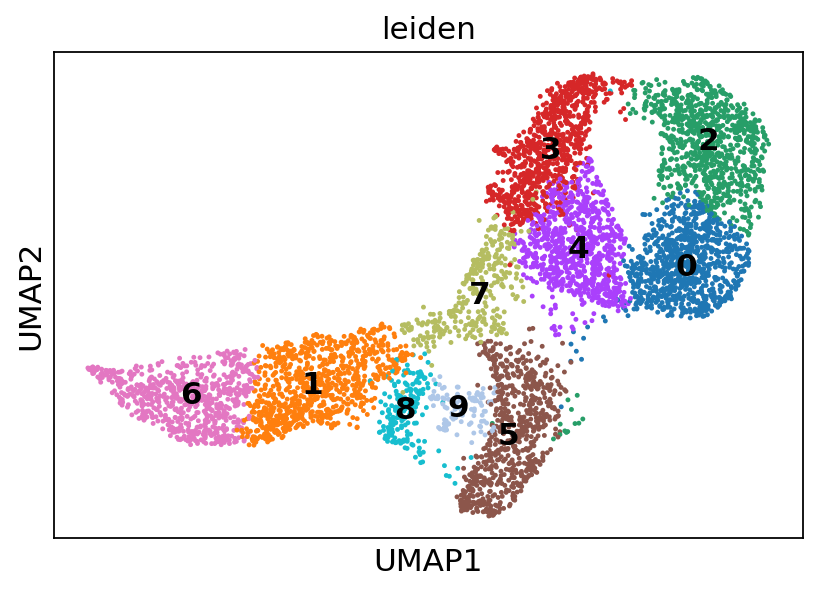

In [4]:
sc.pp.neighbors(adata, n_neighbors=70, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

## Calculate marker genes

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the .raw data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


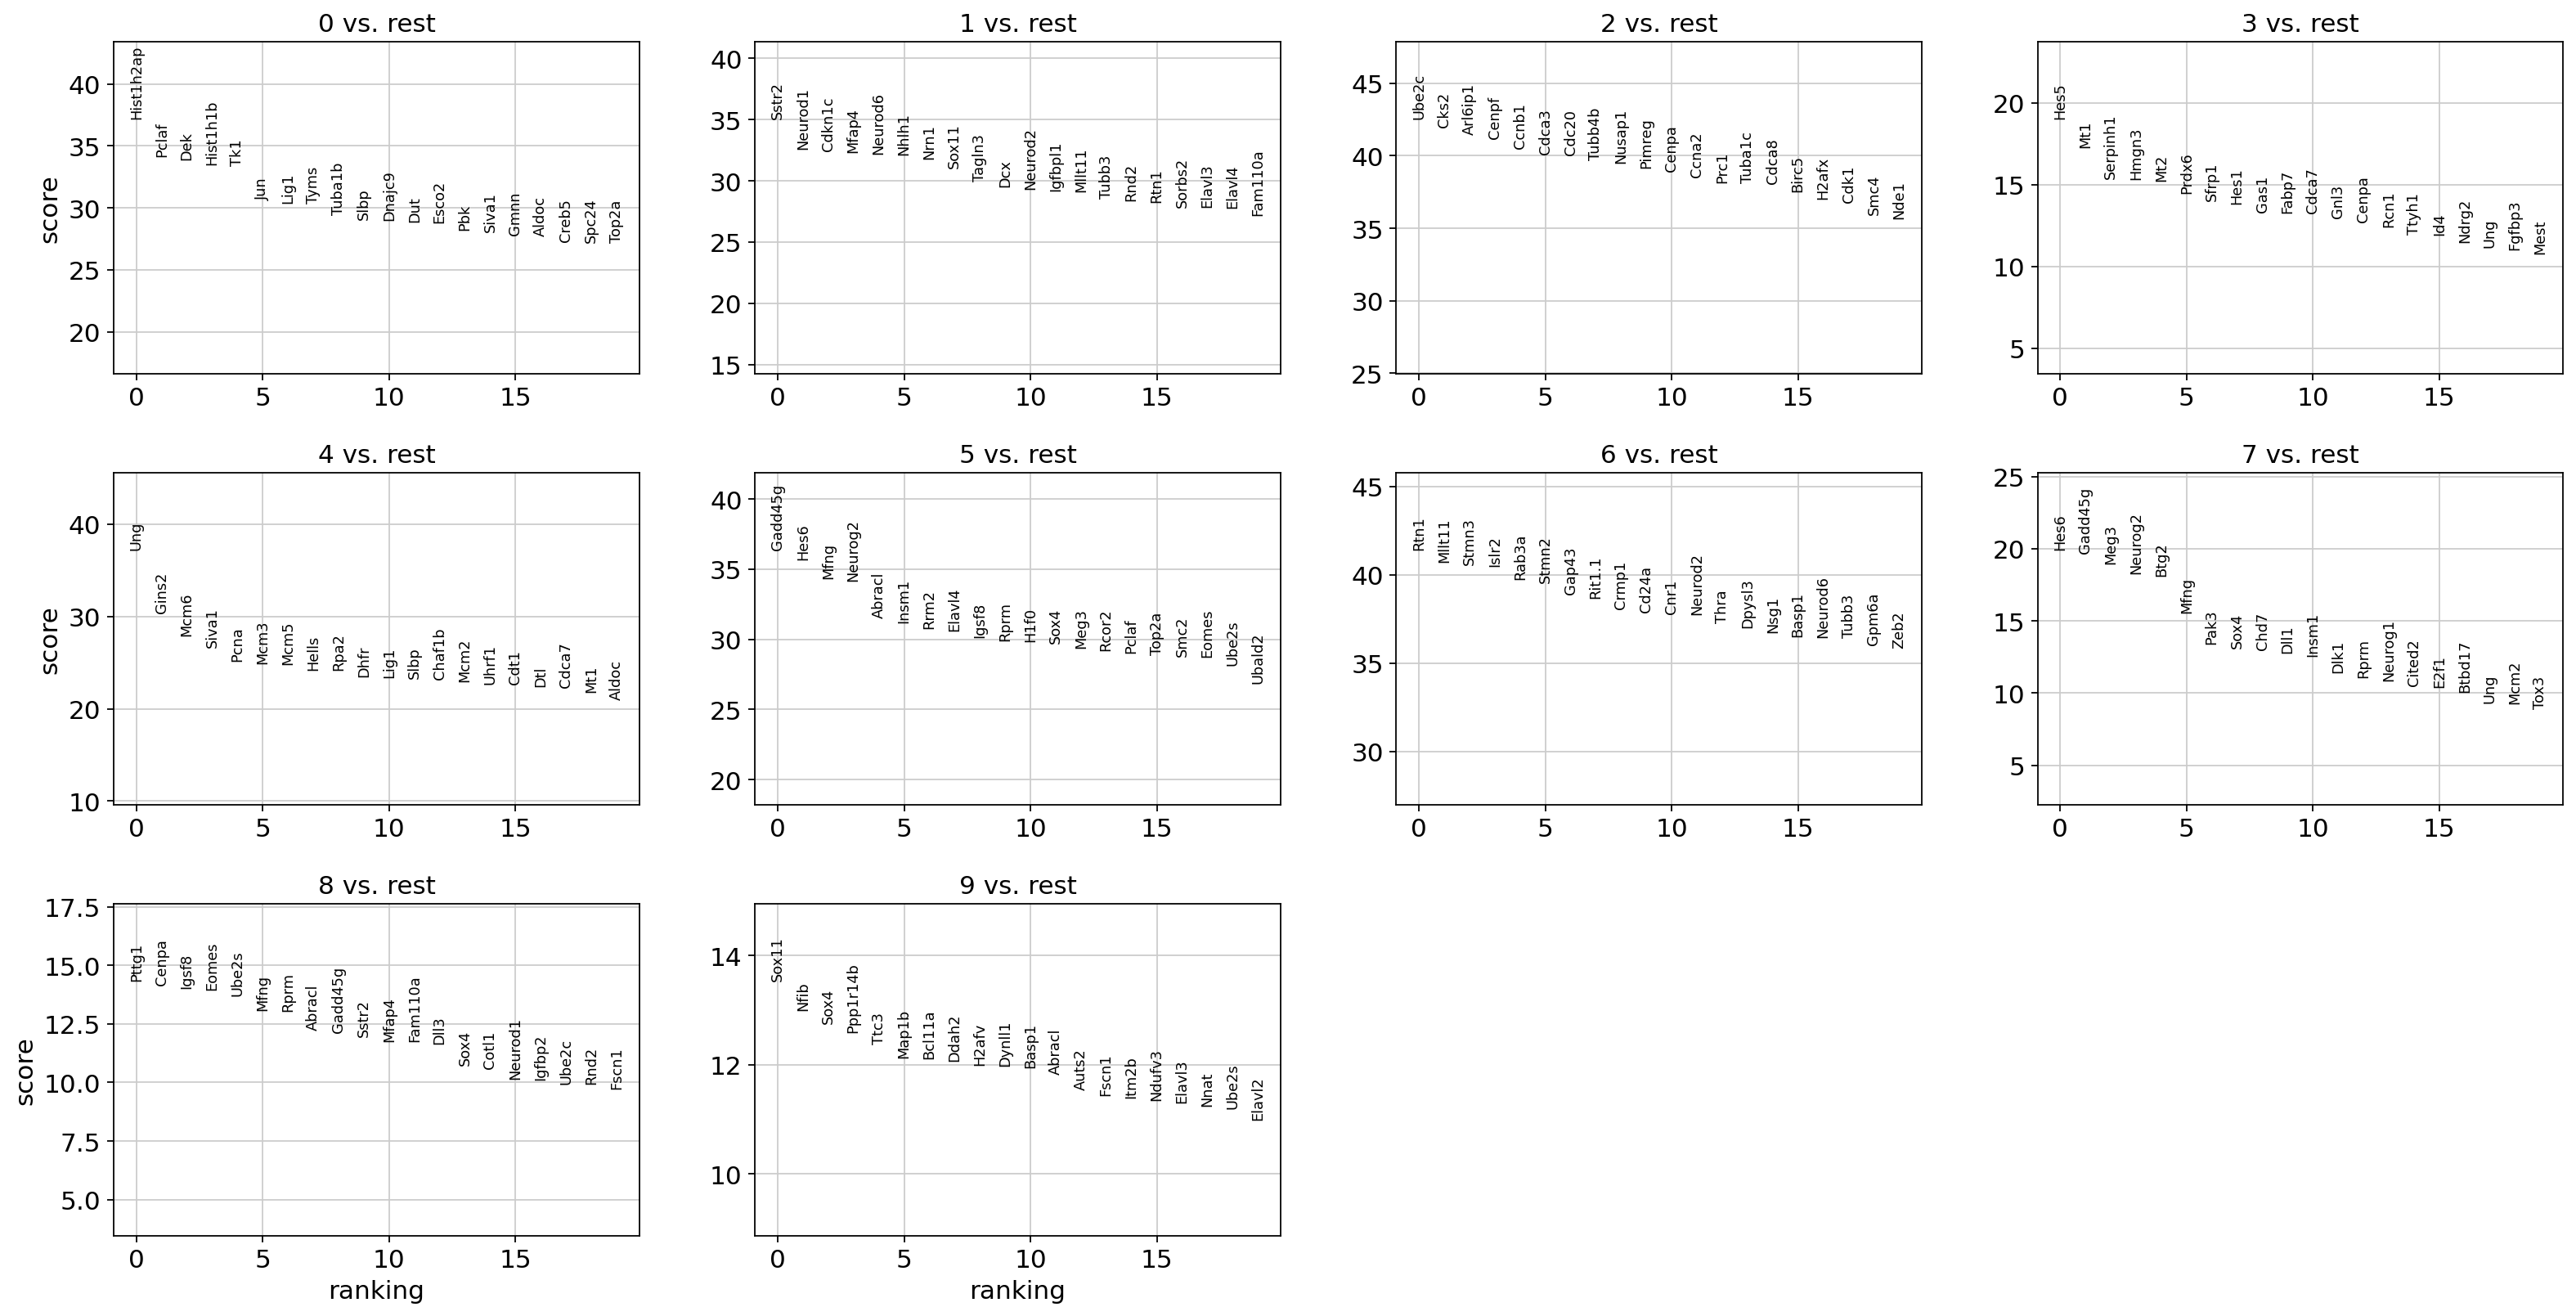

,0,1,2,3,4,5,6,7,8,9
0,Hist1h2ap,Sstr2,Ube2c,Hes5,Ung,Gadd45g,Rtn1,Hes6,Pttg1,Sox11
1,Pclaf,Neurod1,Cks2,Mt1,Gins2,Hes6,Mllt11,Gadd45g,Cenpa,Nfib
2,Dek,Cdkn1c,Arl6ip1,Serpinh1,Mcm6,Mfng,Stmn3,Meg3,Igsf8,Sox4
3,Hist1h1b,Mfap4,Cenpf,Hmgn3,Siva1,Neurog2,Islr2,Neurog2,Eomes,Ppp1r14b
4,Tk1,Neurod6,Ccnb1,Mt2,Pcna,Abracl,Rab3a,Btg2,Ube2s,Ttc3
5,Jun,Nhlh1,Cdca3,Prdx6,Mcm3,Insm1,Stmn2,Mfng,Mfng,Map1b
6,Lig1,Nrn1,Cdc20,Sfrp1,Mcm5,Rrm2,Gap43,Pak3,Rprm,Bcl11a
7,Tyms,Sox11,Tubb4b,Hes1,Hells,Elavl4,Rit1.1,Sox4,Abracl,Ddah2
8,Tuba1b,Tagln3,Nusap1,Gas1,Rpa2,Igsf8,Crmp1,Chd7,Gadd45g,H2afv
9,Slbp,Dcx,Pimreg,Fabp7,Dhfr,Rprm,Cd24a,Dll1,Sstr2,Dynll1


In [5]:
# Calculate marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=True)  # 100 genes by default
# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test_overestim_var', use_raw=True)  # 100 genes by default
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, use_raw=True)

top_ranked_genes_per_cluster = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
top_ranked_genes_per_cluster

In [6]:
ranked_genes = adata.uns['rank_genes_groups']

# Loop through gene names and scores (ordered)
for gene_list, score_list in zip(ranked_genes['names'][:1], ranked_genes['scores'][:1]):
    for gene, score in zip(gene_list, score_list):
        print(gene, score)

Hist1h2ap 37.205635
Sstr2 35.091072
Ube2c 42.569942
Hes5 19.051758
Ung 37.267925
Gadd45g 36.4041
Rtn1 41.42894
Hes6 19.951609
Pttg1 14.353571
Sox11 13.540389


Storing dendrogram info using `.uns['dendrogram_leiden']`


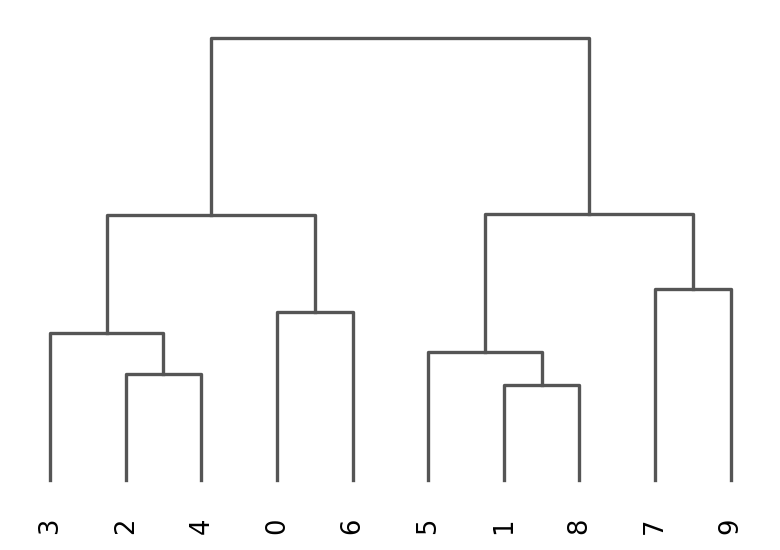

<AxesSubplot:>

In [7]:
sc.tl.dendrogram(adata, groupby='leiden', use_rep='X_umap', var_names=marker_genes, use_raw=False)
sc.pl.dendrogram(adata, groupby='leiden')

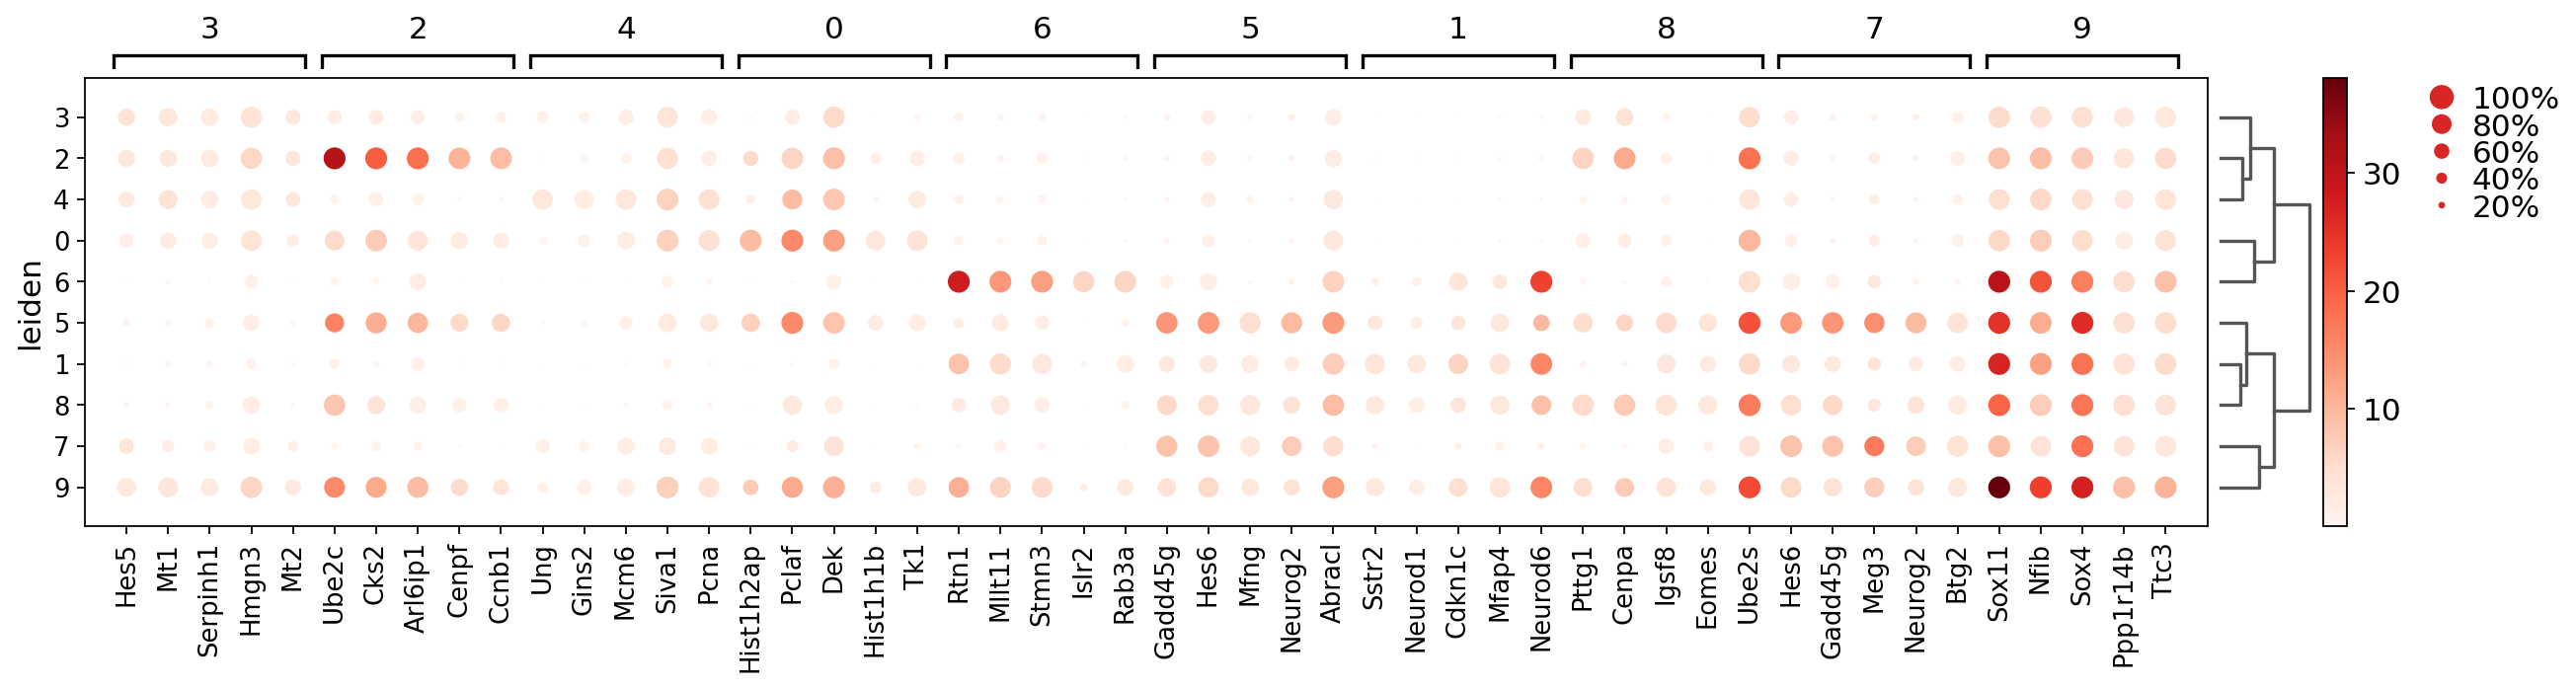

In [8]:
# Makes a dot plot of the expression values of var_names in each cluster
# color: mean expression of a gene within a cluster
# size: fraction of cells expressing the gene in the category
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5)
#                                 values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7)

## Marker gene overlap

To further identify the clusters in our data set, we look at the overlap with a list of known marker genes. These were found by the bulk RNA-seq analysis that was previously performed on the same datasets.

marker_gene_overlap calculates an overlap score between data-deriven marker genes and provided markers

Marker gene overlap scores can be quoted as overlap counts, overlap coefficients, or jaccard indices. The method returns a pandas dataframe which can be used to annotate clusters based on marker gene overlaps.

The numbers in the table below denote the number of genes that are found in both sets, our marker genes and the 100 ranked genes. So, number 3 in (cluster 4, neural_progen) means that all 3 marker genes for neural progenitors (Pax6, Vim, Sox2) were found in the 100 ranked genes.

In [9]:
cell_annotation = sc.tl.marker_gene_overlap(adata, reference_markers=marker_genes, key='rank_genes_groups')
cell_annotation

,0,1,2,3,4,5,6,7,8,9
neural_progen,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
intermediate_progen,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
post_mitotic,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
ectopic,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


We can also visualize the marker gene overlap as a fraction of the total marker genes, and then plot this as a heatmap for simpler cell identity annotation.

For each cluster, this method calculates the intersection of the ranked genes set with the set of the marker genes we have from bulk RNA-seq. If the intersection is an empty set, the value in the heatmap is 0 and so on. In cluster 9, there is no overlap of our marker genes with the ranked genes.

If normalize='reference', the counts at each cell are divided by the total number of our marker genes for each cell type.


<AxesSubplot:>

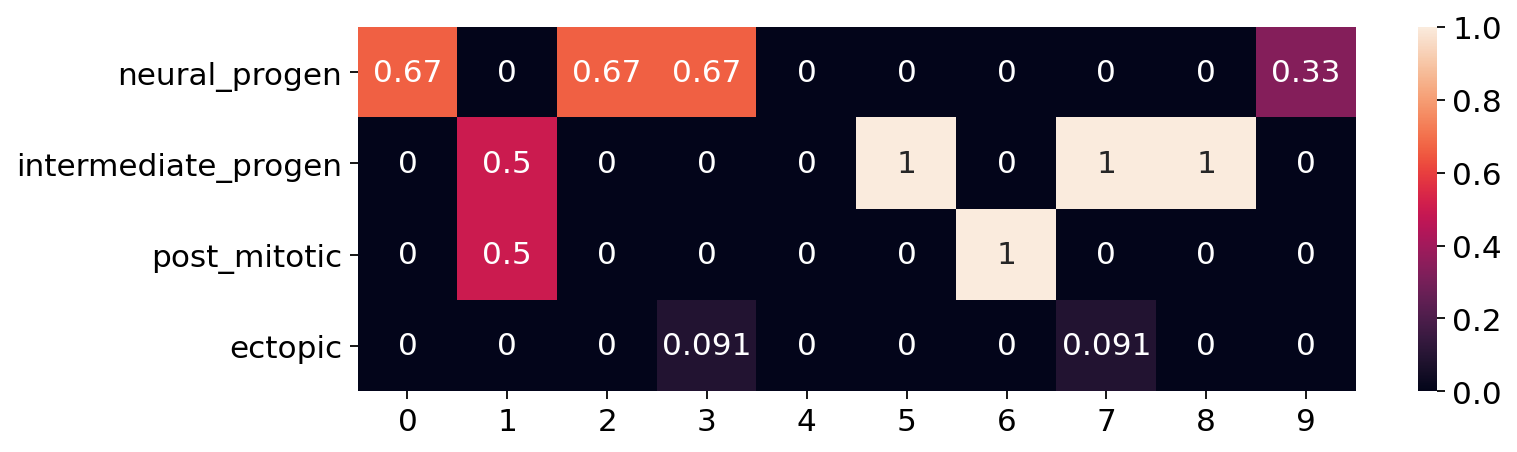

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, reference_markers=marker_genes,
                                                 key='rank_genes_groups', normalize='reference')

sb.heatmap(cell_annotation_norm, cbar=True, annot=True)

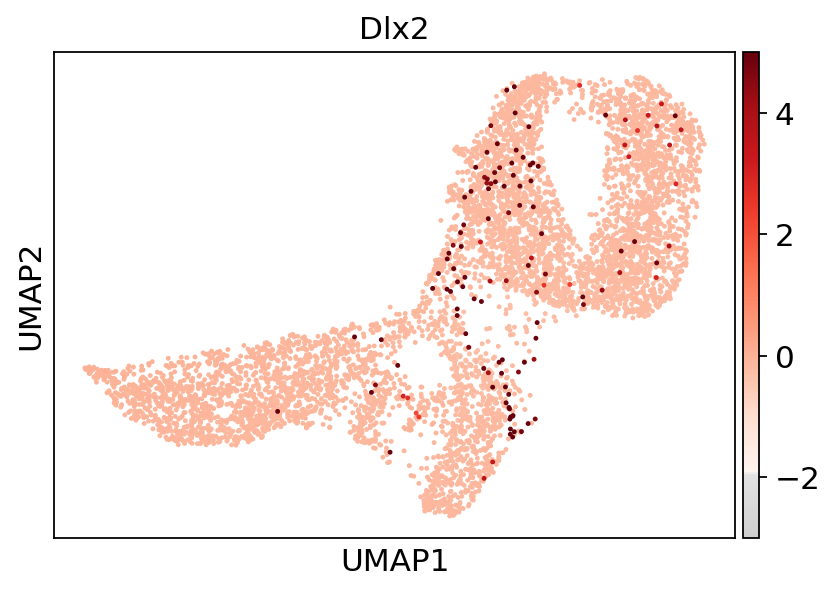

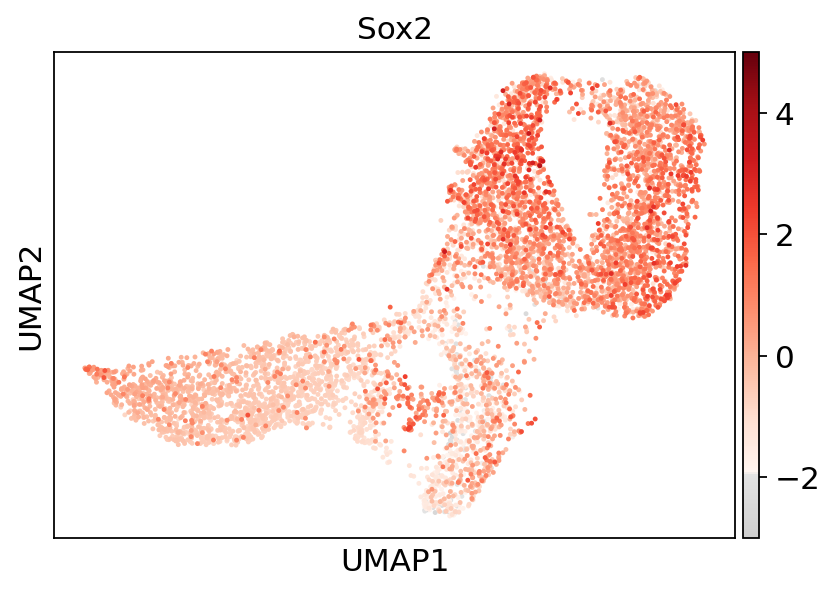

In [14]:
sc.pl.umap(adata, color='Dlx2', vmin=-3, vmax=5, use_raw=False, color_map=mymap)  # ectopic
sc.pl.umap(adata, color='Sox2', vmin=-3, vmax=5, use_raw=False, color_map=mymap)

## Visualise mean expression of each cell type

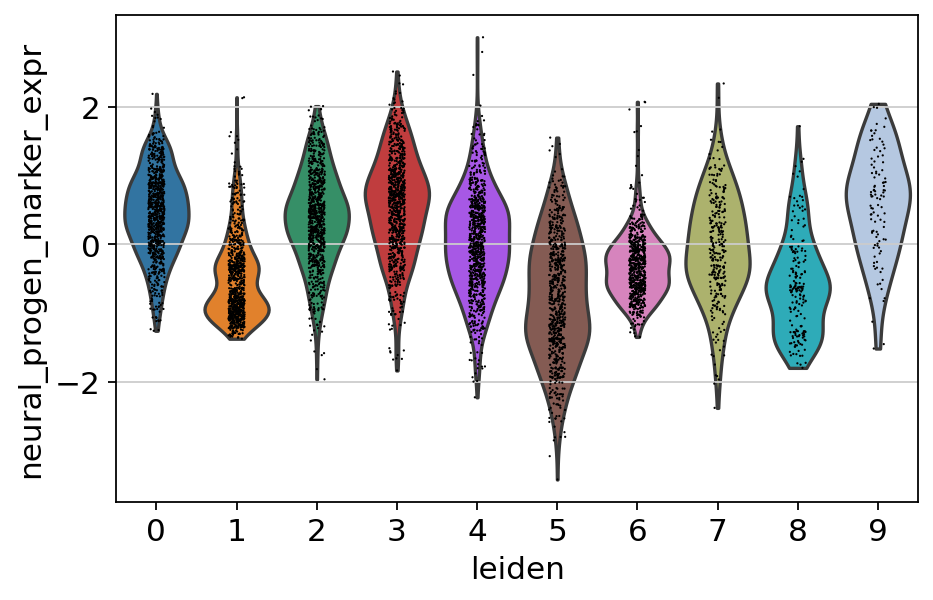

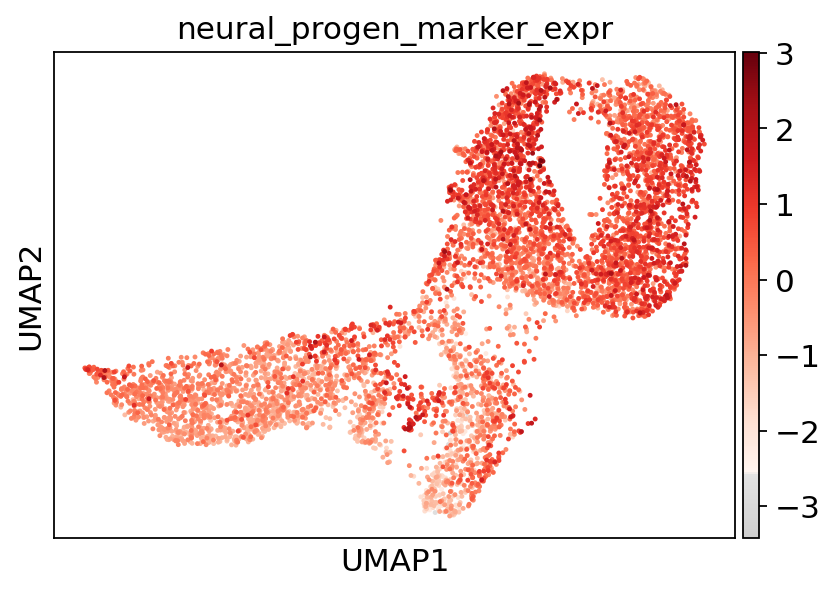

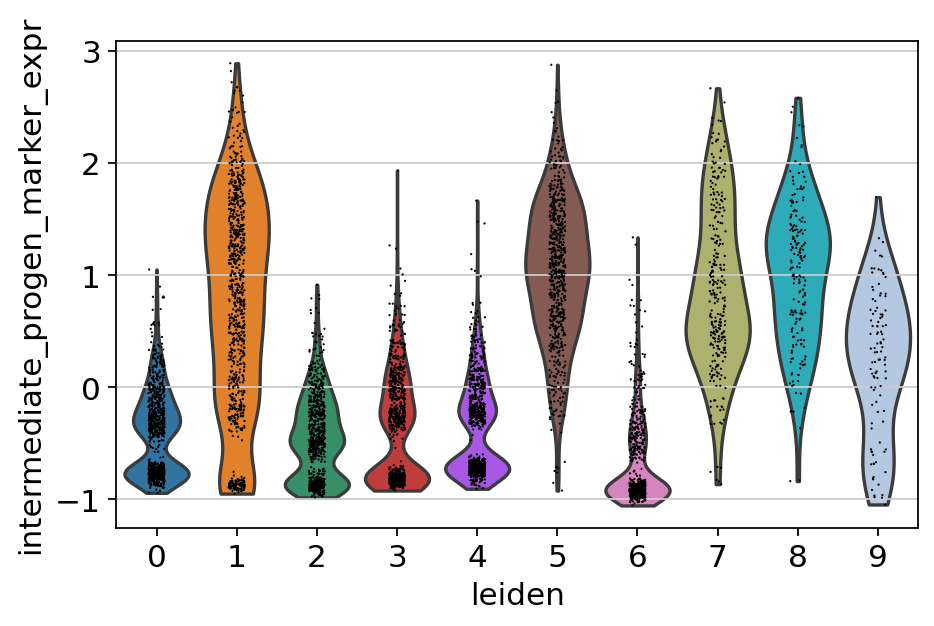

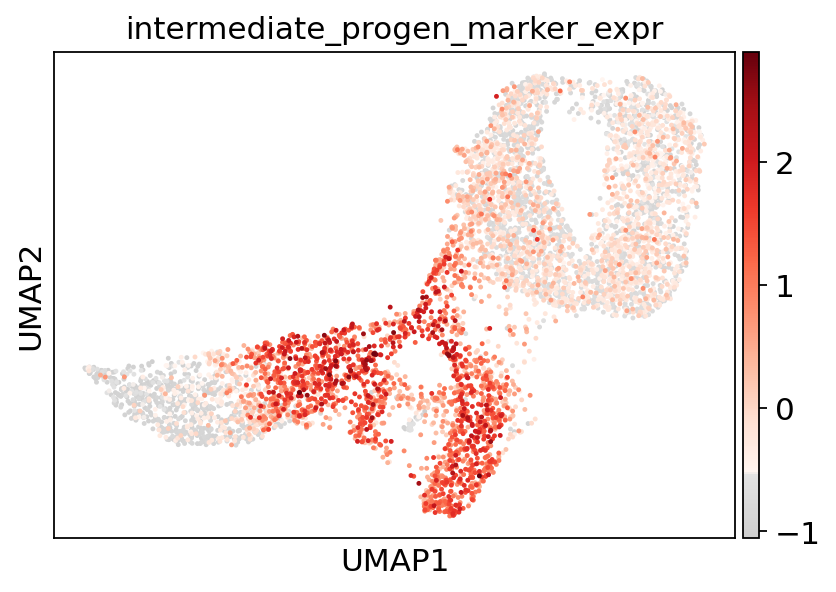

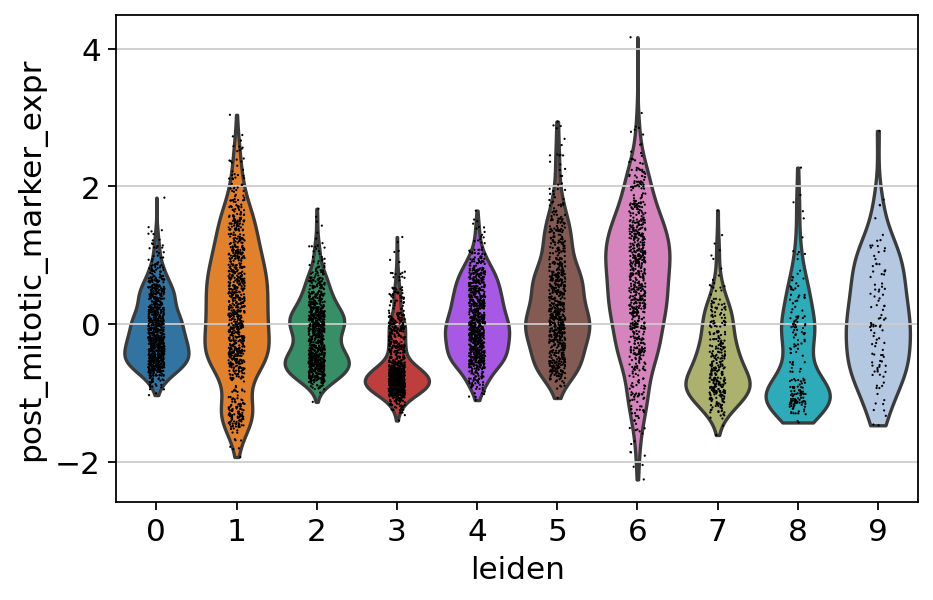

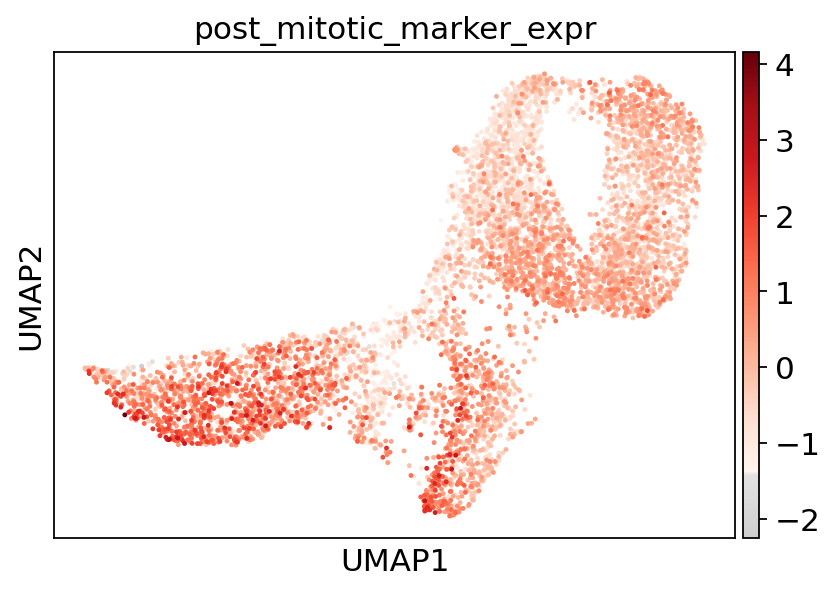

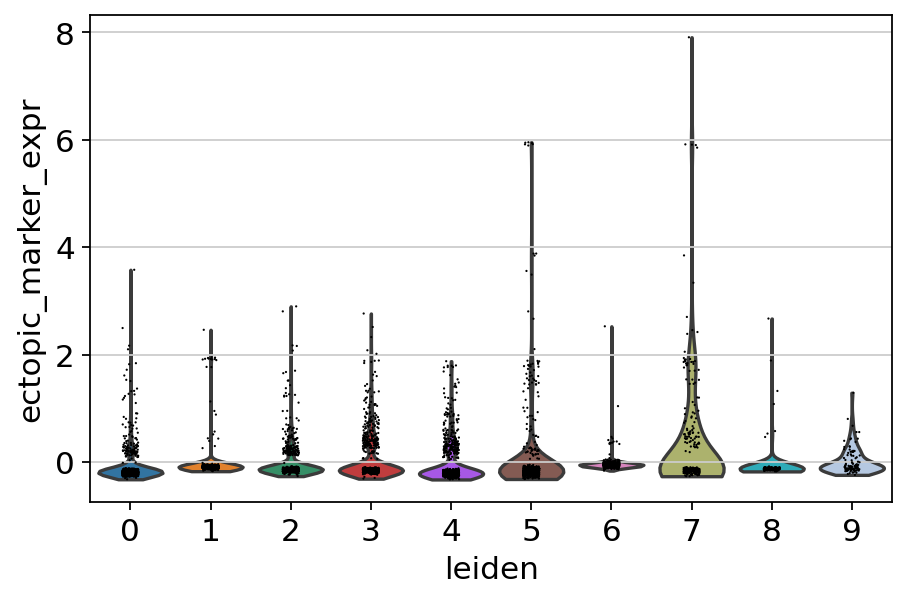

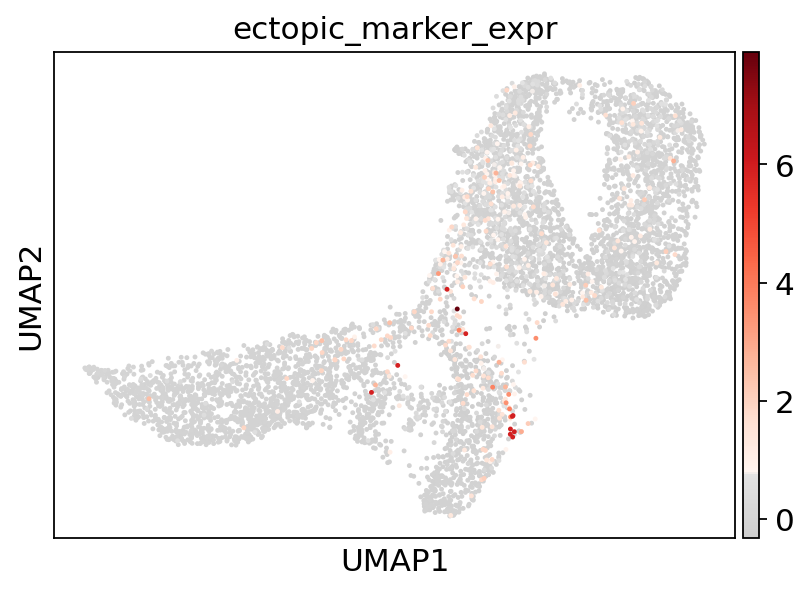

In [15]:
for cell_type in marker_genes.keys():
    cell_type_ids = np.isin(adata.var_names, marker_genes[cell_type])
    
    #Calculate the mean expression of the marker genes in each cell type
    obs_name = cell_type + '_marker_expr'
    adata.obs[obs_name] = adata.X[:, cell_type_ids].mean(1)
    
    #Plot enterocyte expression
    sc.pl.violin(adata, obs_name, groupby='leiden')
    sc.pl.umap(adata, color=obs_name, color_map=mymap)

## Update h5ad file

In [16]:
adata_file = '../ann_data/exp_04/' + dataset + '_norm_variable_genes.h5ad'
adata.write(adata_file)
print('{} file updated'.format(adata_file))

../ann_data/exp_04/E13_hom_norm_variable_genes.h5ad file updated
